# Silver Analytics - US Real Estate

## Analise de qualidade dos dados limpos da camada silver

Dados retirados da one_big_table gerada no banco

## 1. Data Loading

In [1]:
import pandas as pd
import pyspark.sql as psql
from pyspark.sql import SparkSession

import psycopg2
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
DB_CONFIG = {
    'host': 'localhost',
    'port': 5434,
    'database': os.getenv('POSTGRES_DB'),
    'user': os.getenv('POSTGRES_USER'),
    'password': os.getenv('POSTGRES_PASSWORD')
}

db = psycopg2.connect(**DB_CONFIG)
cur = db.cursor()

## 2. Data Analysis

O gráfico de barras abaixo ilustra o impacto da etapa de limpeza no processo de ETL, especificamente na remoção de registros com valores nulos. A análise visual revela que, embora a porcentagem total de nulos tenha se mantido similar, observa-se uma padronização na distribuição desses valores entre grupos de colunas. Esse padrão é resultado direto da regra de negócio aplicada durante a transformação, que categorizou os registros em dois tipos distintos:

1. **Imovel:** Necessário `house_size`, `bath`, `bed`, `rooms`, `price_per_sqft`
2. **Lotes:** Necessário `acre_lot`, `price_per_acre`

Consequentemente, é esperado e coerente que permaneçam valores nulos em certas colunas, uma vez que um lote não possui os mesmos atributos de um imóvel construído. Quanto às demais colunas que ainda apresentam nulos, como `prev_sold_date`, avaliou-se, dentro do contexto analítico, que sua ausência é lógica e admissível. Por exemplo, `prev_sold_date` só é relevante para imóveis com `status` igual a 'sold', justificando sua omissão nos demais casos.



### 2.1 Geral

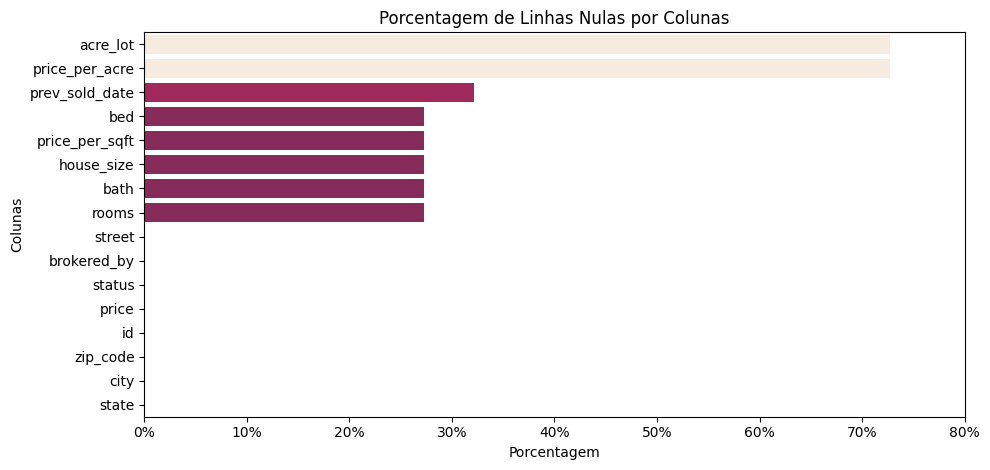

In [5]:
db.rollback()

cur.execute('SELECT COUNT(*) FROM silver.one_big_table;')
total = cur.fetchone()[0]

cur.execute('SELECT * FROM silver.one_big_table LIMIT 0;')
colunas = [d[0] for d in cur.description]

data = []
for coluna in colunas:
    cur.execute(f'SELECT COUNT("{coluna}") FROM silver.one_big_table')
    n_nulos = cur.fetchone()[0]
    nulos = total - n_nulos
    porcentagem = round((nulos * 100) / total, 2)
    data.append((coluna, nulos, porcentagem))

aux = pd.DataFrame(data, columns=["colunas", "qntd_null", "%"])
aux = aux.sort_values("%", ascending=False)

plt.figure(figsize=(10, len(aux)*0.3))
sns.barplot(data=aux, y='colunas', x='%', hue='%', palette='rocket', legend=False)

ax = plt.gca()
tick_locations = ax.get_xticks()
ax.set_xticks(tick_locations)
ax.set_xticklabels([f'{x:.0f}%' for x in tick_locations])

plt.xlabel('Porcentagem')
plt.ylabel('Colunas')
plt.title('Porcentagem de Linhas Nulas por Colunas')
plt.tight_layout()
plt.show()

A tabela abaixo fornece uma visão consolidada dos intervalos de valores das variáveis principais após a etapa de limpeza. A análise desses intervalos permite inferir a diversidade tipológica dos imóveis na base, abrangendo desde unidades compactas, como apartamentos de menor metragem, até propriedades de grande escala, a exemplo de mansões e imóveis de luxo.

In [6]:
data = []
cols = ["price", "acre_lot", "house_size", "bed", "bath", "price_per_sqft", "price_per_acre", "rooms"]

for coluna in cols:
    cur.execute(f'SELECT MIN("{coluna}"), MAX("{coluna}"), AVG("{coluna}"), STDDEV_POP("{coluna}") FROM silver.one_big_table;')
    mini, maxi, med, desv = cur.fetchone()
    data.append((coluna, mini, maxi, med, desv))

df_pd = pd.DataFrame(data, columns=["colunas", "min", "max", "avg", "desvio"])
pd.options.display.float_format = '{:.2f}'.format
df_pd.head(15)

,colunas,min,max,avg,desvio
0,price,20000.00,295000000.00,608252.01,1325731.16
1,acre_lot,0.03,50.00,4.43,8.55
2,house_size,300.00,60000.00,2026.98,1228.74
3,bed,1.00,108.00,3.2383315057203123,1.2796631092569113
4,bath,1.00,198.00,2.5986448307653624,1.2984927344821192
5,price_per_sqft,150.00,45787.55,344.07,328.77
6,price_per_acre,437.54,246875005.52,808481.70,3291785.86
7,rooms,2.00,297.00,5.8369763364856748,2.3790986660863647


In [7]:
# 1. Preço x frequencia
cur.execute("SELECT price, COUNT(*) as price_freq FROM silver.one_big_table GROUP BY price ORDER BY price")
f_price = pd.DataFrame(cur.fetchall(), columns=['price', 'price_freq'])

# 2. Tamanho da casa x frequencia
cur.execute("SELECT house_size, COUNT(*) as hs_freq FROM silver.one_big_table WHERE house_size IS NOT NULL GROUP BY house_size ORDER BY house_size")
f_hs = pd.DataFrame(cur.fetchall(), columns=['house_size', 'hs_freq'])

# 3. Tamanho do lote x frequencia
cur.execute("SELECT acre_lot, COUNT(*) as al_freq FROM silver.one_big_table WHERE acre_lot IS NOT NULL GROUP BY acre_lot ORDER BY acre_lot")
f_al = pd.DataFrame(cur.fetchall(), columns=['acre_lot', 'al_freq'])

# 4. Bed e Bath x frequencia
cur.execute("""
    SELECT bed, COUNT(*) as bed_freq, bath, COUNT(*) as bath_freq FROM silver.one_big_table 
    WHERE house_size IS NOT NULL AND bed < 110 AND bath < 200
    GROUP BY bed, bath
    ORDER BY bed DESC
""")
bedbath = pd.DataFrame(
    cur.fetchall(), 
    columns=['bed', 'bed_freq', 'bath', 'bath_freq']
)

A sequência de gráficos abaixo demonstra a evolução do processamento ETL na camada Silver. Nota-se, inicialmente, uma redução significativa nos intervalos de todas as variáveis, resultado da remoção de outliers em múltiplos campos do dataset. Essa depuração permitiu uma visualização mais detalhada e precisa das distribuições.

Os gráficos de preço e de banheiros/quartos sugerem, à primeira vista, que poucas alterações foram realizadas nessas áreas. No entanto, essa aparente estabilidade é explicada pela regra de negócio aplicada. A fonte original dos dados é uma plataforma de anúncios imobiliários, análoga às existentes no Brasil, onde a inserção manual pode gerar inconsistências — como valores exorbitantes ou zerados.

Para contornar isso, foi definido um intervalo realista com base em pesquisa, considerando a ampla variedade de ofertas, desde imóveis simples até propriedades de luxo, o que justifica a amplitude final. Quanto aos banheiros/quartos, o intervalo reflete a diversidade tipológica dos imóveis listados, incluindo complexos residenciais que elevam consideravelmente o número de cômodos.

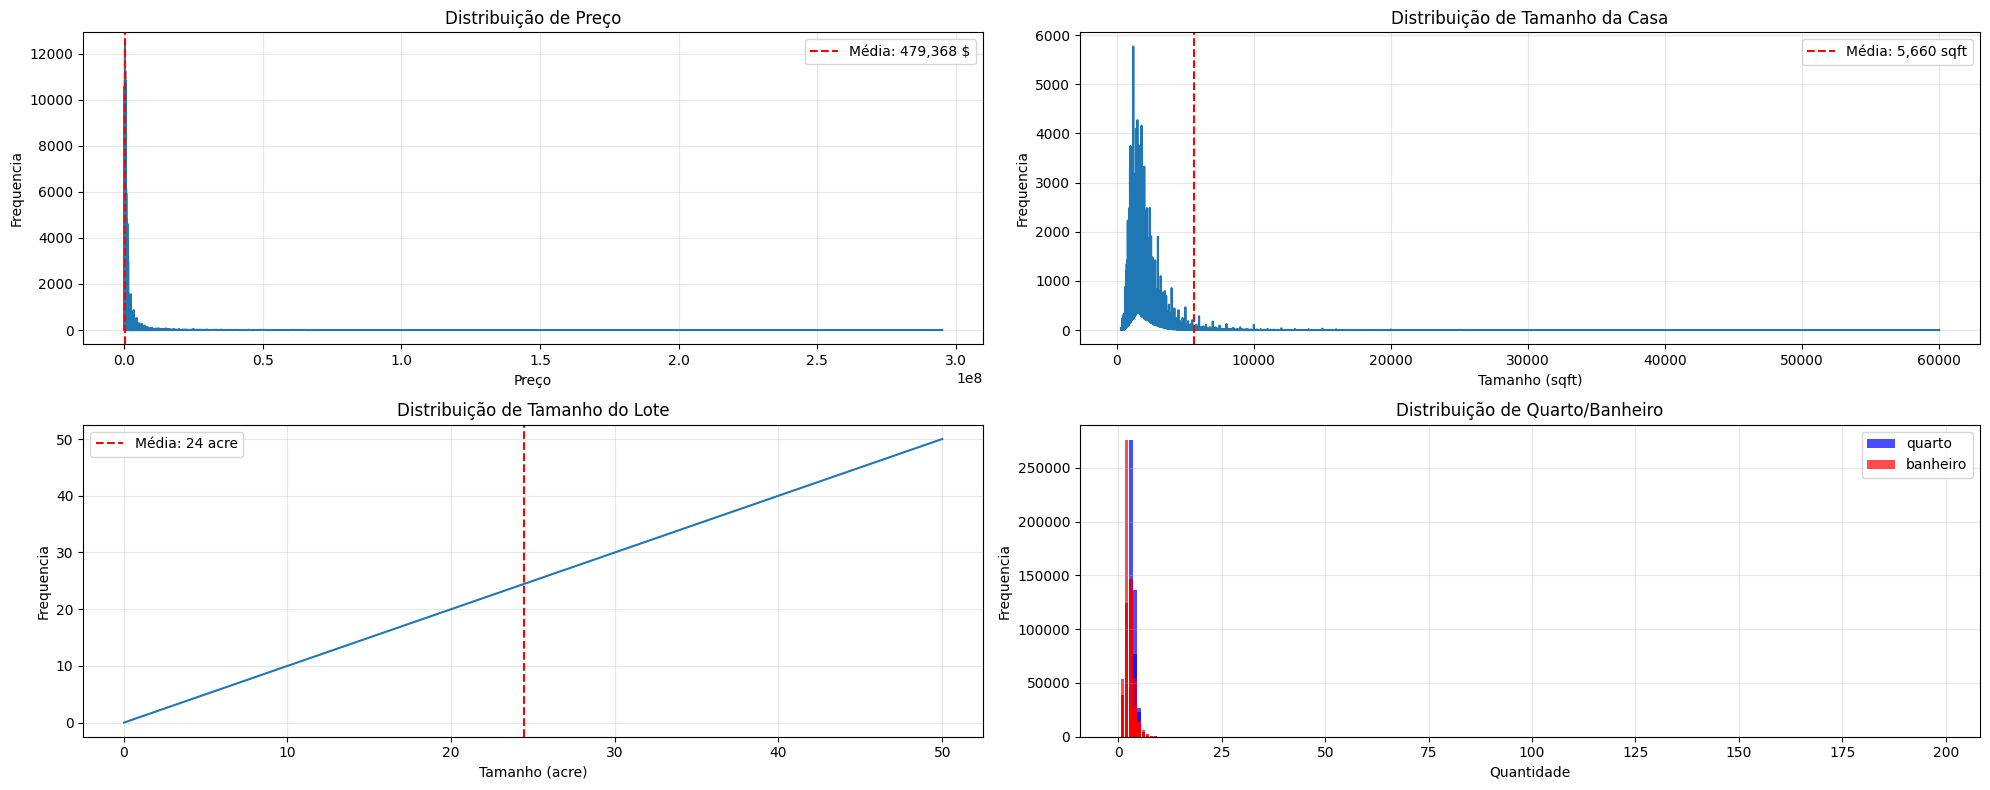

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))

# Grafico de preço x frequencia

axs[0, 0].plot(f_price['price'], f_price['price_freq'])
axs[0, 0].axvline(f_price['price'].median(), color='r', linestyle='--', label=f'Média: {f_price["price"].median():,.0f} $')

axs[0, 0].set_title('Distribuição de Preço')
axs[0, 0].set_xlabel('Preço')
axs[0, 0].set_ylabel('Frequencia')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# Grafico de house_size x frequencia

axs[0, 1].plot(f_hs['house_size'], f_hs['hs_freq'])
axs[0, 1].axvline(f_hs['house_size'].median(), color='r', linestyle='--', label=f'Média: {f_hs["house_size"].median():,.0f} sqft')

axs[0, 1].set_title('Distribuição de Tamanho da Casa')
axs[0, 1].set_xlabel('Tamanho (sqft)')
axs[0, 1].set_ylabel('Frequencia')
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# Grafico de acre_lot x frequencia

axs[1, 0].plot(f_al['acre_lot'], f_al['acre_lot'])
axs[1, 0].axvline(f_al['acre_lot'].median(), color='r', linestyle='--', label=f'Média: {f_al["acre_lot"].median():,.0f} acre')

axs[1, 0].set_title('Distribuição de Tamanho do Lote')
axs[1, 0].set_xlabel('Tamanho (acre)')
axs[1, 0].set_ylabel('Frequencia')
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)

# Grafico de bed+bath x frequencia
axs[1, 1].bar(bedbath['bed'], bedbath['bed_freq'], label='quarto', alpha=0.7, color='blue')
axs[1, 1].bar(bedbath['bath'], bedbath['bath_freq'], label='banheiro', alpha=0.7, color='red')

axs[1, 1].set_title('Distribuição de Quarto/Banheiro')
axs[1, 1].set_xlabel('Quantidade')
axs[1, 1].set_ylabel('Frequencia')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 Por estado

#### 2.2.1 Casas

Abaixo é realizada uma análise da distribuição de imóveis por estado. O primeiro gráfico evidencia uma disparidade significativa na amostragem, com três estados concentrando a maior parte dos registros do dataset. Devido ao volume substancial de dados disponíveis para essas unidades federativas, as estatísticas e inferências extraídas a partir delas podem ser consideradas as mais representativas e confiáveis da base.

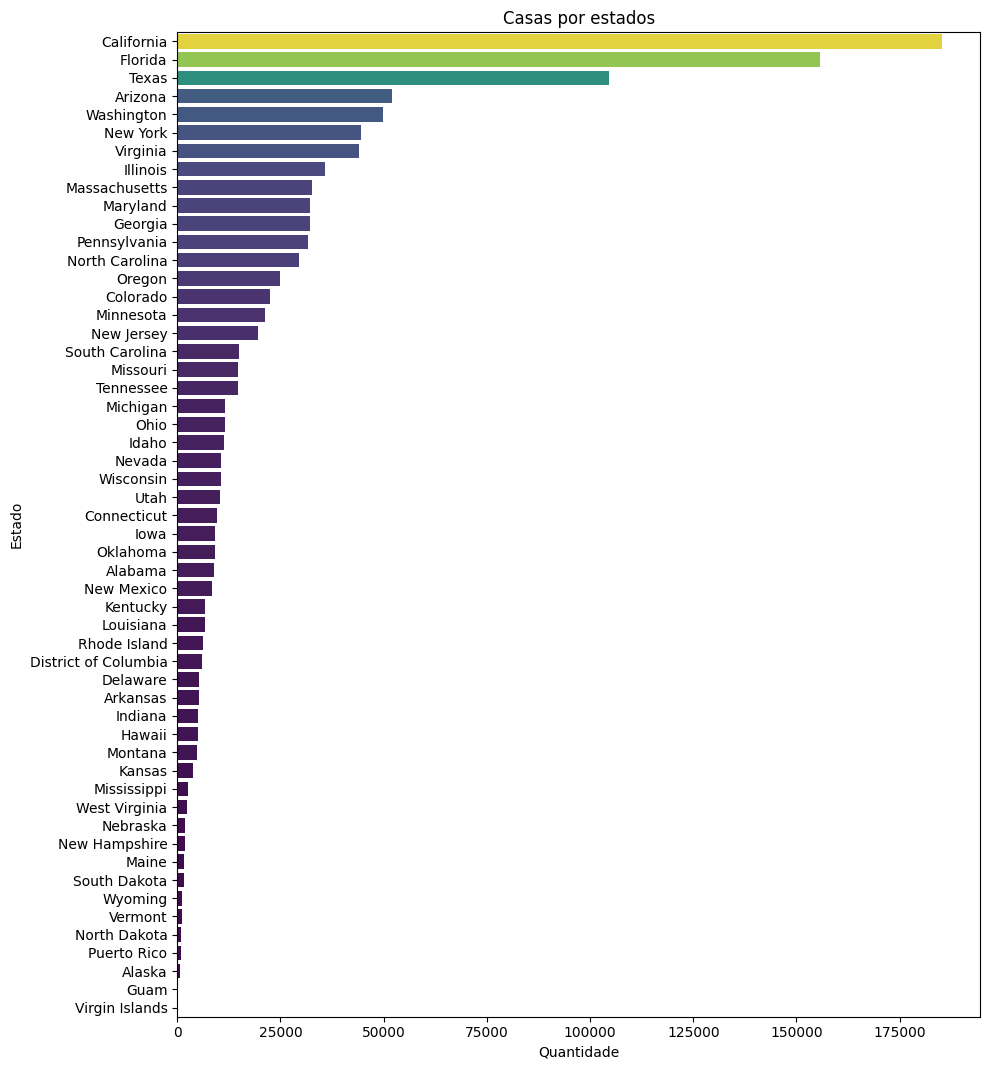

In [9]:
db.rollback()
cur.execute('SELECT state, COUNT(*) AS quantidade FROM silver.one_big_table WHERE house_size IS NOT NULL GROUP BY state ORDER BY quantidade DESC')

aux = pd.DataFrame(cur.fetchall(), columns=['state', 'quantidade'])

plt.figure(figsize=(10, len(aux)*0.2))
sns.barplot(data=aux, y='state', x='quantidade', hue='quantidade', palette='viridis', legend=False)
plt.xlabel('Quantidade')
plt.ylabel('Estado')
plt.title('Casas por estados')
plt.tight_layout()
plt.show()

Nos gráficos abaixo, observa-se que a localização estadual exerce forte influência sobre o preço médio dos imóveis. Tomando como exemplo um estado com alta representatividade amostral e preço médio elevado, **Nova York** destaca-se não apenas por sua notoriedade cultural e turística — frequentemente retratada no cinema —, mas também pela limitada disponibilidade de espaço urbano, fatores que justificam sua valorização imobiliária.

**Havaí** e **Ilhas Virgens**, por sua vez, apresentam preços médios significativamente altos, ainda que possuam baixa representatividade no *dataset*. Esse comportamento pode ser atribuído à presença de poucos imóveis de alto padrão listados, os quais elevam a média local de forma expressiva.

No que se refere ao **tamanho médio das residências**, os estados se concentram em um intervalo relativamente estreito, com exceção das **Ilhas Virgens**, cujo valor médio — inflacionado pela escassez de registros — destoa da tendência geral.

De modo geral, estados com quantidade mediana de imóveis também mantêm preços dentro de uma faixa intermediária, sugerindo que há oportunidades de compra em diversas regiões para perfis com orçamento limitado.

Ressalta-se, contudo, que esta análise considera apenas a variável estadual, não incluindo outros fatores decisivos na aquisição de um imóvel, como infraestrutura local, indicadores socioeconômicos ou características específicas da propriedade.

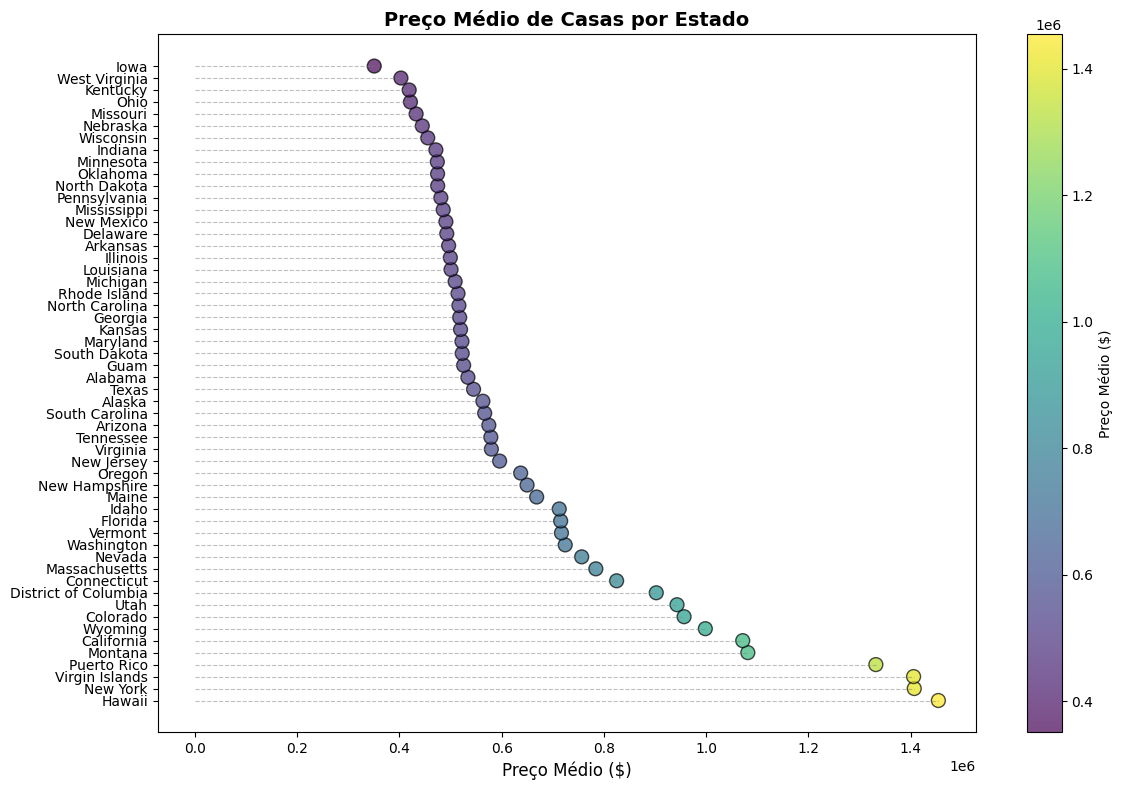

In [10]:
cur.execute("""
    SELECT 
        state,
        ROUND(AVG(price)::numeric, 2) as price_media
    FROM silver.one_big_table 
    WHERE house_size IS NOT NULL
    GROUP BY state
    ORDER BY price_media DESC
""")

aux = pd.DataFrame(cur.fetchall(), columns=['state', 'price_media'])

fig, ax = plt.subplots(figsize=(12, 8))

state_to_num = {state: i for i, state in enumerate(aux['state'])}
aux['state_num'] = aux['state'].map(state_to_num)

scatter = ax.scatter(aux['price_media'], aux['state_num'], 
                     c=aux['price_media'], 
                     cmap='viridis', 
                     s=100,
                     alpha=0.7,
                     edgecolors='black')

for price, y in zip(aux['price_media'], aux['state_num']):
    ax.hlines(y=y, xmin=0, xmax=price, 
              colors='gray', linestyles='dashed', alpha=0.5, linewidth=0.8)

ax.set_yticks(range(len(aux['state'])))
ax.set_yticklabels(aux['state'])
ax.set_xlabel('Preço Médio ($)', fontsize=12)
ax.set_title('Preço Médio de Casas por Estado', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Preço Médio ($)')

plt.tight_layout()
plt.show()

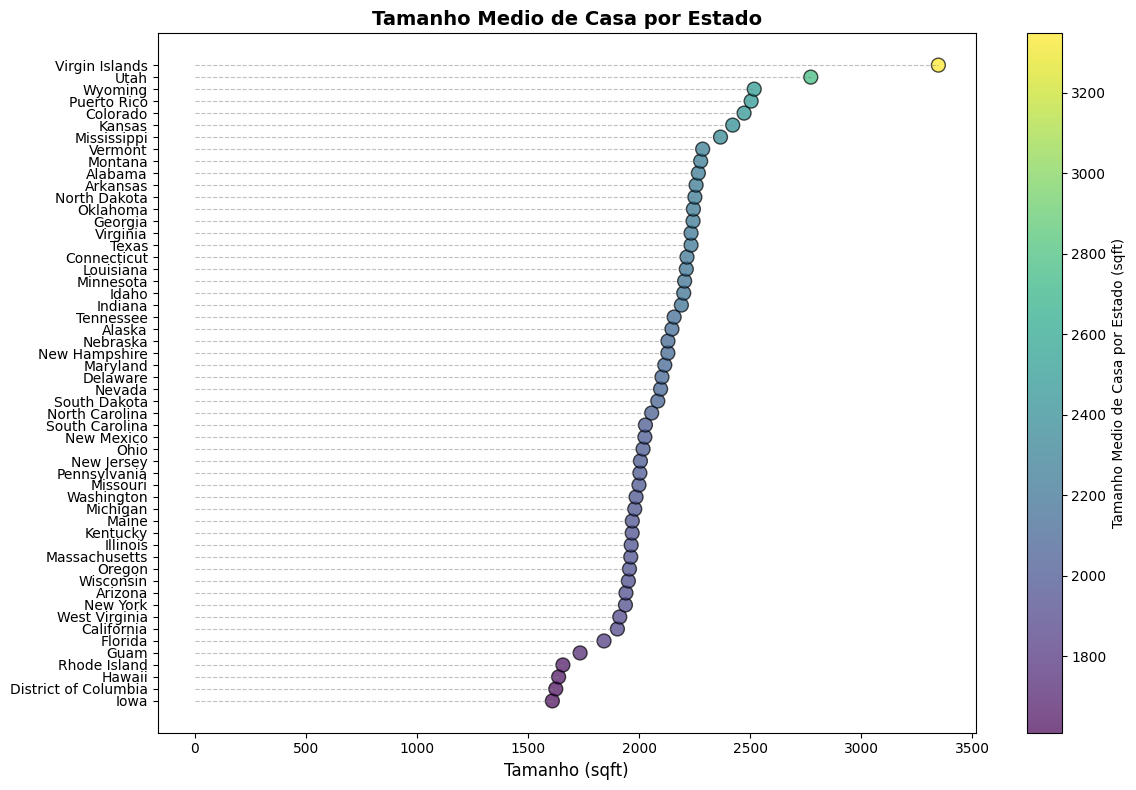

In [ ]:
cur.execute("""
    SELECT 
        state,
        ROUND(AVG(house_size)::numeric, 2) as hs_media
    FROM one_big_table 
    WHERE house_size IS NOT NULL
    GROUP BY state
    ORDER BY hs_media
""")

aux = pd.DataFrame(cur.fetchall(), columns=['state', 'hs_media'])

fig, ax = plt.subplots(figsize=(12, 8))

state_to_num = {state: i for i, state in enumerate(aux['state'])}
aux['state_num'] = aux['state'].map(state_to_num)

# Scatter plot com colormap válido
scatter = ax.scatter(aux['hs_media'], aux['state_num'], 
                     c=aux['hs_media'], 
                     cmap='viridis', 
                     s=100,
                     alpha=0.7,
                     edgecolors='black')

for price, y in zip(aux['hs_media'], aux['state_num']):
    ax.hlines(y=y, xmin=0, xmax=price, 
              colors='gray', linestyles='dashed', alpha=0.5, linewidth=0.8)

ax.set_yticks(range(len(aux['state'])))
ax.set_yticklabels(aux['state'])
ax.set_xlabel('Tamanho (sqft)', fontsize=12)
ax.set_title('Tamanho Medio de Casa por Estado', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Tamanho Medio de Casa por Estado (sqft)')

plt.tight_layout()
plt.show()

O gráfico abaixo apresenta a média do preço por metro quadrado por estado. Complementando as análises anteriores, e desconsiderando os estados com baixa representatividade amostral, observa-se que **Nova York** se destaca como um mercado imobiliário de **alto custo e complexidade**.

Essa conclusão é suportada pela leitura integrada dos gráficos: Nova York apresenta, em média, **imóveis de menor metragem**, porém com **preços totais elevados**, impulsionados por um **custo por pé quadrado significativamente alto**.

Em contrapartida, estados como **Oklahoma** e **Kansas** emergem como mercados mais acessíveis. Embora não possuam a projeção econômica global de Nova York, apresentam **custos por metro quadrado bem inferiores** à média nacional e encontram-se em **fase de valorização e crescimento econômico consistente**.

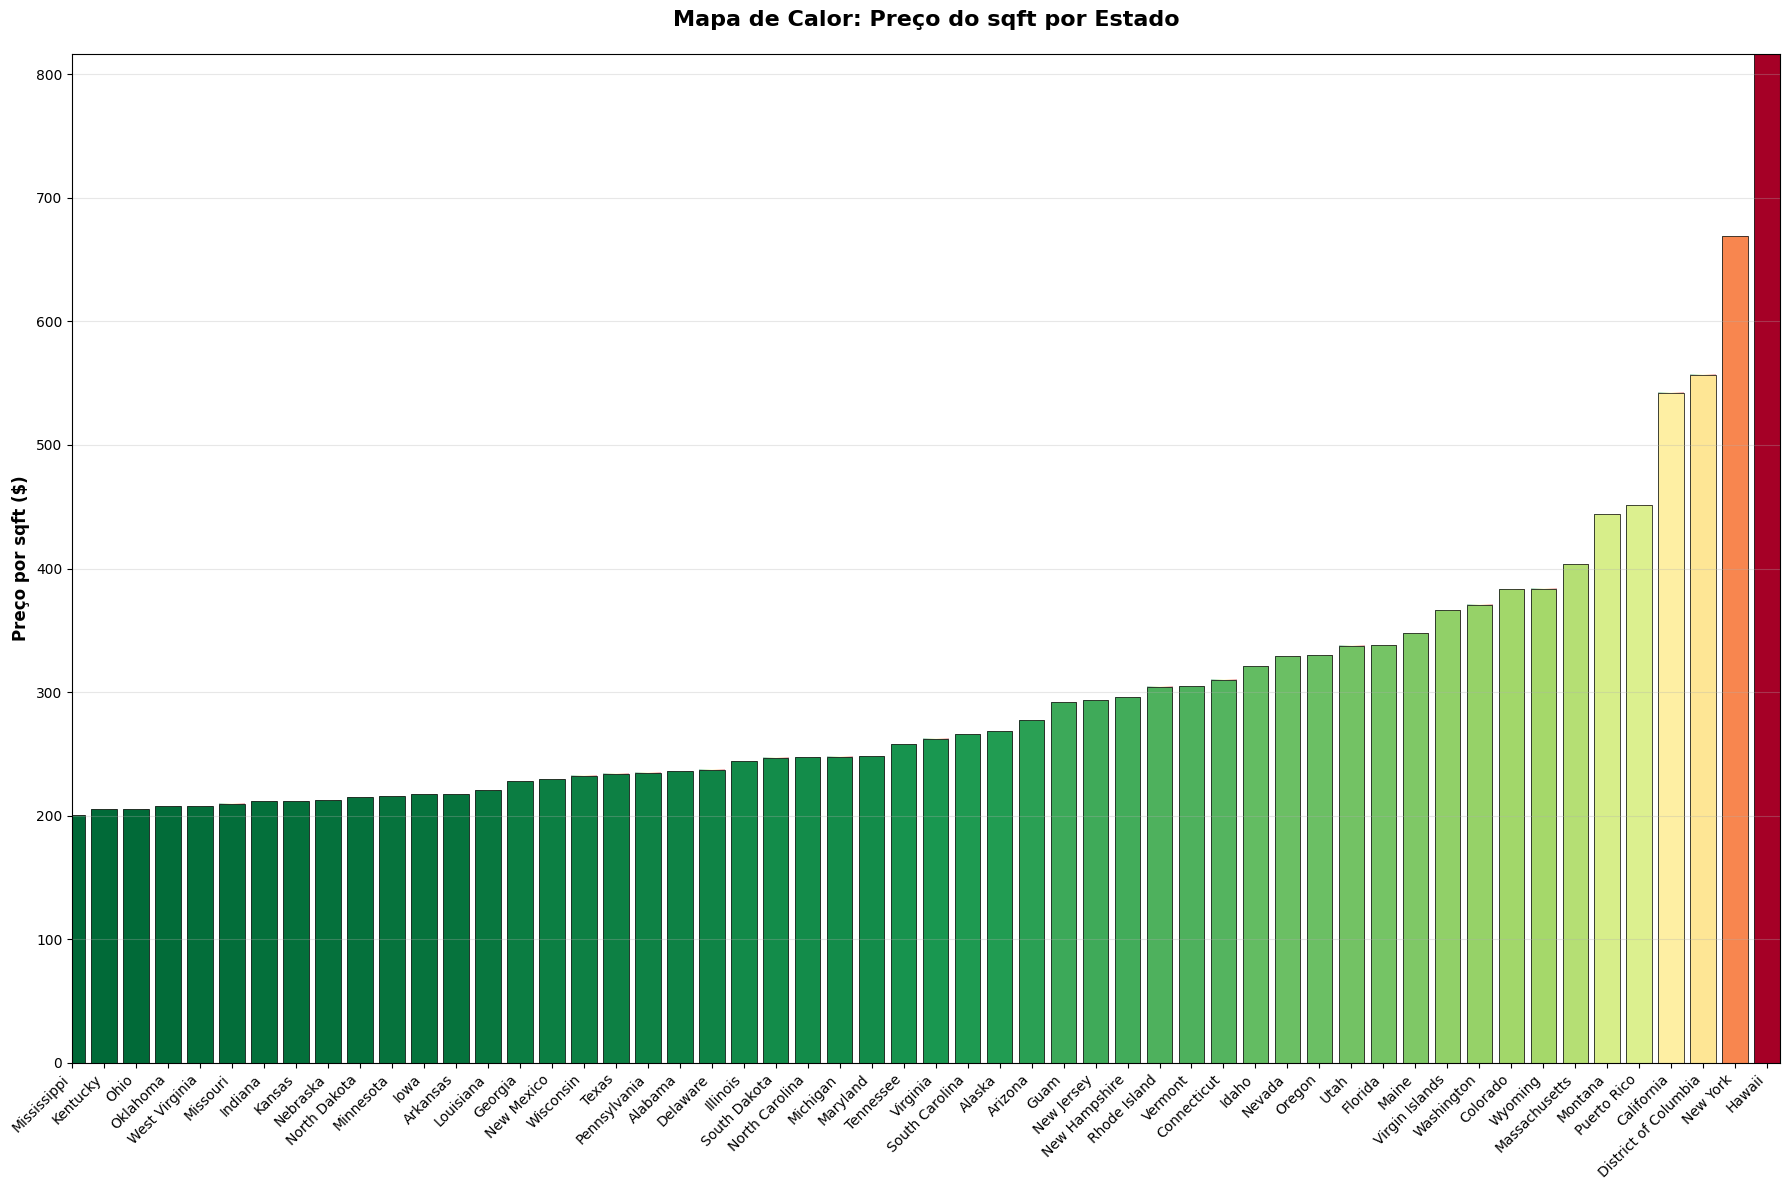

In [11]:
db.rollback()
cur.execute('''
    SELECT state, AVG(price_per_sqft) as avg_price_per_sqft 
    FROM silver.one_big_table 
    WHERE house_size IS NOT NULL 
    GROUP BY state 
    ORDER BY avg_price_per_sqft
''')
data = cur.fetchall()

fig, ax = plt.subplots(figsize=(18, 12))

states = [row[0] for row in data]
prices = [row[1] for row in data]

norm = plt.Normalize(min(prices), max(prices))
colors = plt.cm.RdYlGn_r(norm(prices))

x_pos = np.arange(len(states))
bars = ax.bar(x_pos, prices, color=colors, edgecolor='black', linewidth=0.5)

# Adicionar sombra para efeito 3D
for i, bar in enumerate(bars):
    gradient = np.linspace(0, 1, 100).reshape(1, -1)
    ax.imshow(gradient, extent=[bar.get_x(), bar.get_x() + bar.get_width(), 
                                0, bar.get_height()],
              aspect='auto', cmap='RdYlGn_r', alpha=0.3,
              origin='lower')

ax.set_xticks(x_pos)
ax.set_xticklabels(states, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Preço por sqft ($)', fontsize=12, fontweight='bold')
ax.set_title('Mapa de Calor: Preço do sqft por Estado', 
             fontsize=16, fontweight='bold', pad=20)

ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 2.2.2 Lotes

O gráfico abaixo corrobora uma tendência previamente identificada: determinados estados apresentam uma representatividade desproporcional no *dataset*, dominando tanto a amostra de imóveis construídos quanto a de lotes.

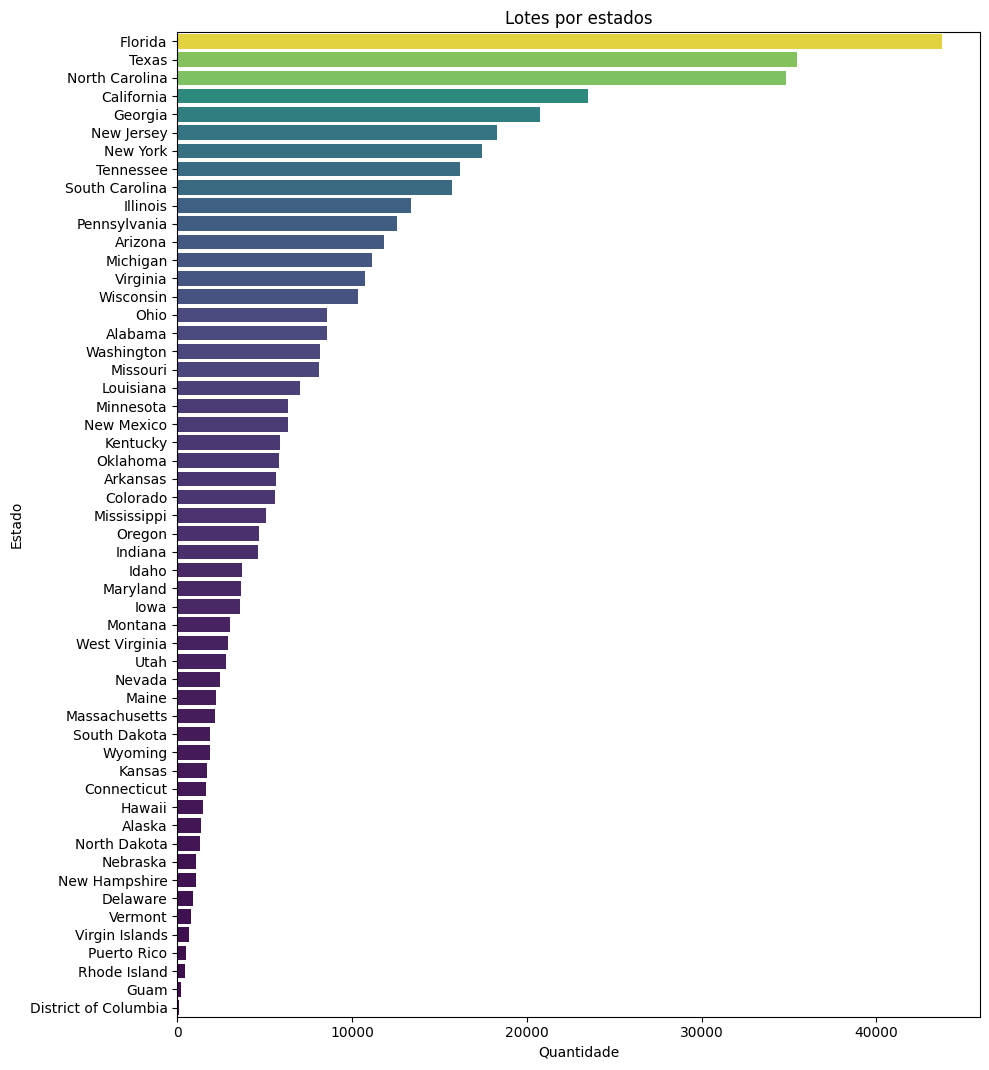

In [12]:
db.rollback()
cur.execute('SELECT state, COUNT(*) AS quantidade FROM silver.one_big_table WHERE acre_lot IS NOT NULL GROUP BY state ORDER BY quantidade DESC')

aux = pd.DataFrame(cur.fetchall(), columns=['state', 'quantidade'])

plt.figure(figsize=(10, len(aux)*0.2))
sns.barplot(data=aux, y='state', x='quantidade', hue='quantidade', palette='viridis', legend=False)
plt.xlabel('Quantidade')
plt.ylabel('Estado')
plt.title('Lotes por estados')
plt.tight_layout()
plt.show()

Observa-se também uma tendência de convergência para a média na maioria dos estados, com alguns apresentando desvios significativos. Essas discrepâncias podem ser atribuídas tanto a fatores geográficos — como estados de menor extensão territorial, onde a escassez de espaço eleva o valor do acre — quanto à baixa representatividade amostral de certas unidades federativas, cujos poucos registros podem distorcer a média.

É relevante destacar que o **Distrito de Columbia**, sede da capital federal, apresenta o **preço médio por acre mais elevado** entre todas as unidades analisadas.

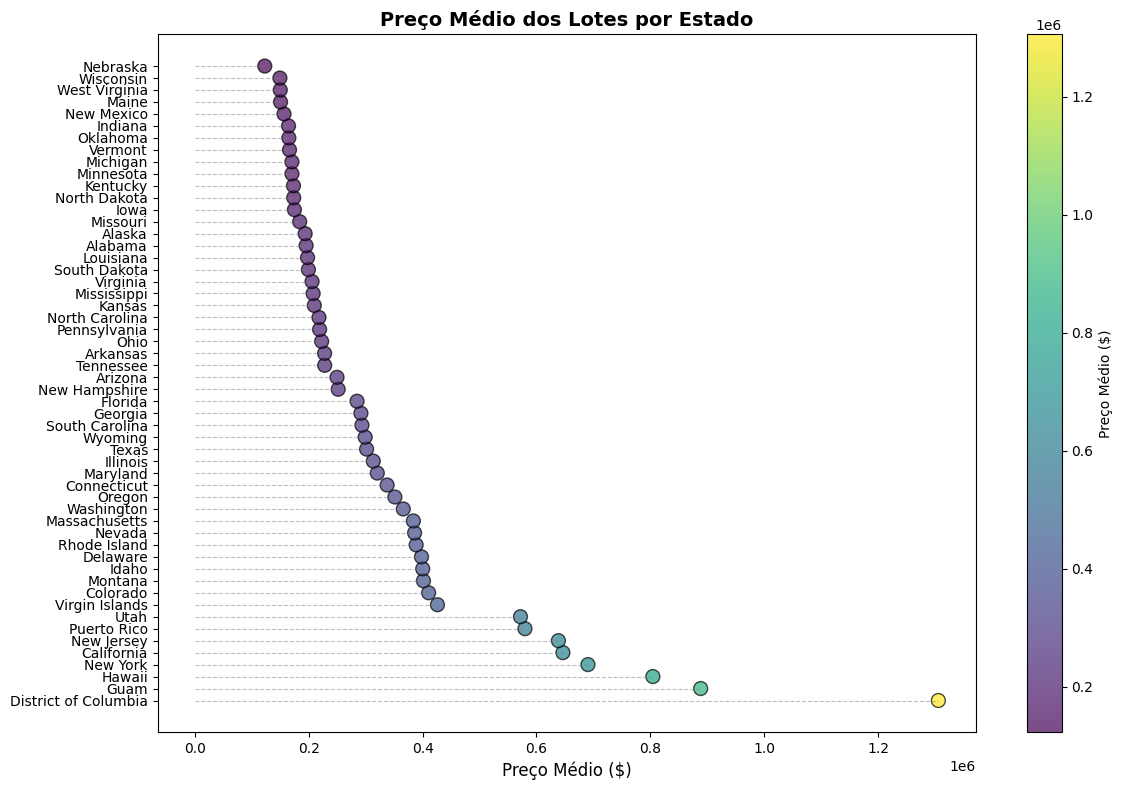

In [13]:
cur.execute("""
    SELECT 
        state,
        ROUND(AVG(price)::numeric, 2) as price_media
    FROM silver.one_big_table 
    WHERE acre_lot IS NOT NULL
    GROUP BY state
    ORDER BY price_media DESC
""")

aux = pd.DataFrame(cur.fetchall(), columns=['state', 'price_media'])

fig, ax = plt.subplots(figsize=(12, 8))

state_to_num = {state: i for i, state in enumerate(aux['state'])}
aux['state_num'] = aux['state'].map(state_to_num)

scatter = ax.scatter(aux['price_media'], aux['state_num'], 
                     c=aux['price_media'], 
                     cmap='viridis', 
                     s=100,
                     alpha=0.7,
                     edgecolors='black')

for price, y in zip(aux['price_media'], aux['state_num']):
    ax.hlines(y=y, xmin=0, xmax=price, 
              colors='gray', linestyles='dashed', alpha=0.5, linewidth=0.8)

ax.set_yticks(range(len(aux['state'])))
ax.set_yticklabels(aux['state'])
ax.set_xlabel('Preço Médio ($)', fontsize=12)
ax.set_title('Preço Médio dos Lotes por Estado', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Preço Médio ($)')

plt.tight_layout()
plt.show()

Neste gráfico, observa-se uma mudança no panorama anterior. Estados que antes se situavam na média passam a ocupar as primeiras posições. Essa alteração possui uma explicação consistente: todos os estados que compõem o topo da distribuição compartilham a característica de **possuírem extensas áreas territoriais**, frequentemente destinadas à **agricultura** ou a **lotes industriais**. Consequentemente, são mercados com **maior oferta de terrenos**, o que se reflete diretamente na dinâmica de preços apresentada.

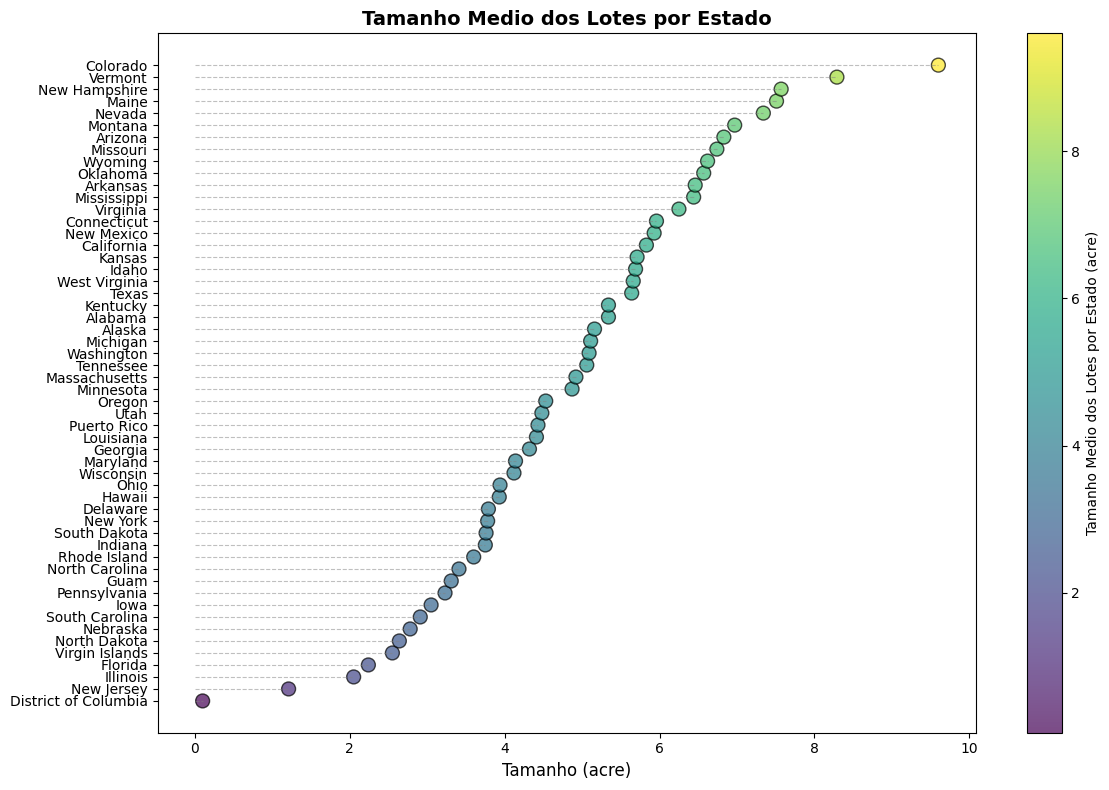

In [14]:
cur.execute("""
    SELECT 
        state,
        ROUND(AVG(acre_lot)::numeric, 2) as acre_media
    FROM silver.one_big_table 
    WHERE acre_lot IS NOT NULL
    GROUP BY state
    ORDER BY acre_media
""")

aux = pd.DataFrame(cur.fetchall(), columns=['state', 'acre_media'])

fig, ax = plt.subplots(figsize=(12, 8))

state_to_num = {state: i for i, state in enumerate(aux['state'])}
aux['state_num'] = aux['state'].map(state_to_num)

# Scatter plot com colormap válido
scatter = ax.scatter(aux['acre_media'], aux['state_num'], 
                     c=aux['acre_media'], 
                     cmap='viridis', 
                     s=100,
                     alpha=0.7,
                     edgecolors='black')

for price, y in zip(aux['acre_media'], aux['state_num']):
    ax.hlines(y=y, xmin=0, xmax=price, 
              colors='gray', linestyles='dashed', alpha=0.5, linewidth=0.8)

ax.set_yticks(range(len(aux['state'])))
ax.set_yticklabels(aux['state'])
ax.set_xlabel('Tamanho (acre)', fontsize=12)
ax.set_title('Tamanho Medio dos Lotes por Estado', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Tamanho Medio dos Lotes por Estado (acre)')

plt.tight_layout()
plt.show()

Novamente observa-se um valor que, à primeira vista, assemelha-se a um *outlier*. No entanto, trata-se de uma distorção completamente compreensível. O **Distrito de Columbia** possui uma área total de aproximadamente 177 km², dos quais cerca de 158 km² são terra firme. Convertido, seu território equivale a cerca de 40.000 acres — uma extensão limitada, sobretudo considerando que grande parte já está ocupada por infraestrutura urbana. Conforme evidenciado no gráfico anterior, a região apresenta a menor média de tamanho de lote entre todas as unidades analisadas.

Conclui-se, portanto, que os lotes disponíveis no Distrito de Columbia são **escassos, reduzidos em tamanho e extremamente valorizados**, o que eleva drasticamente o preço médio por acre. Esse comportamento reflete as condições específicas de um mercado saturado e de alta demanda, afastando a interpretação inicial de que se trataria de um dado atípico.

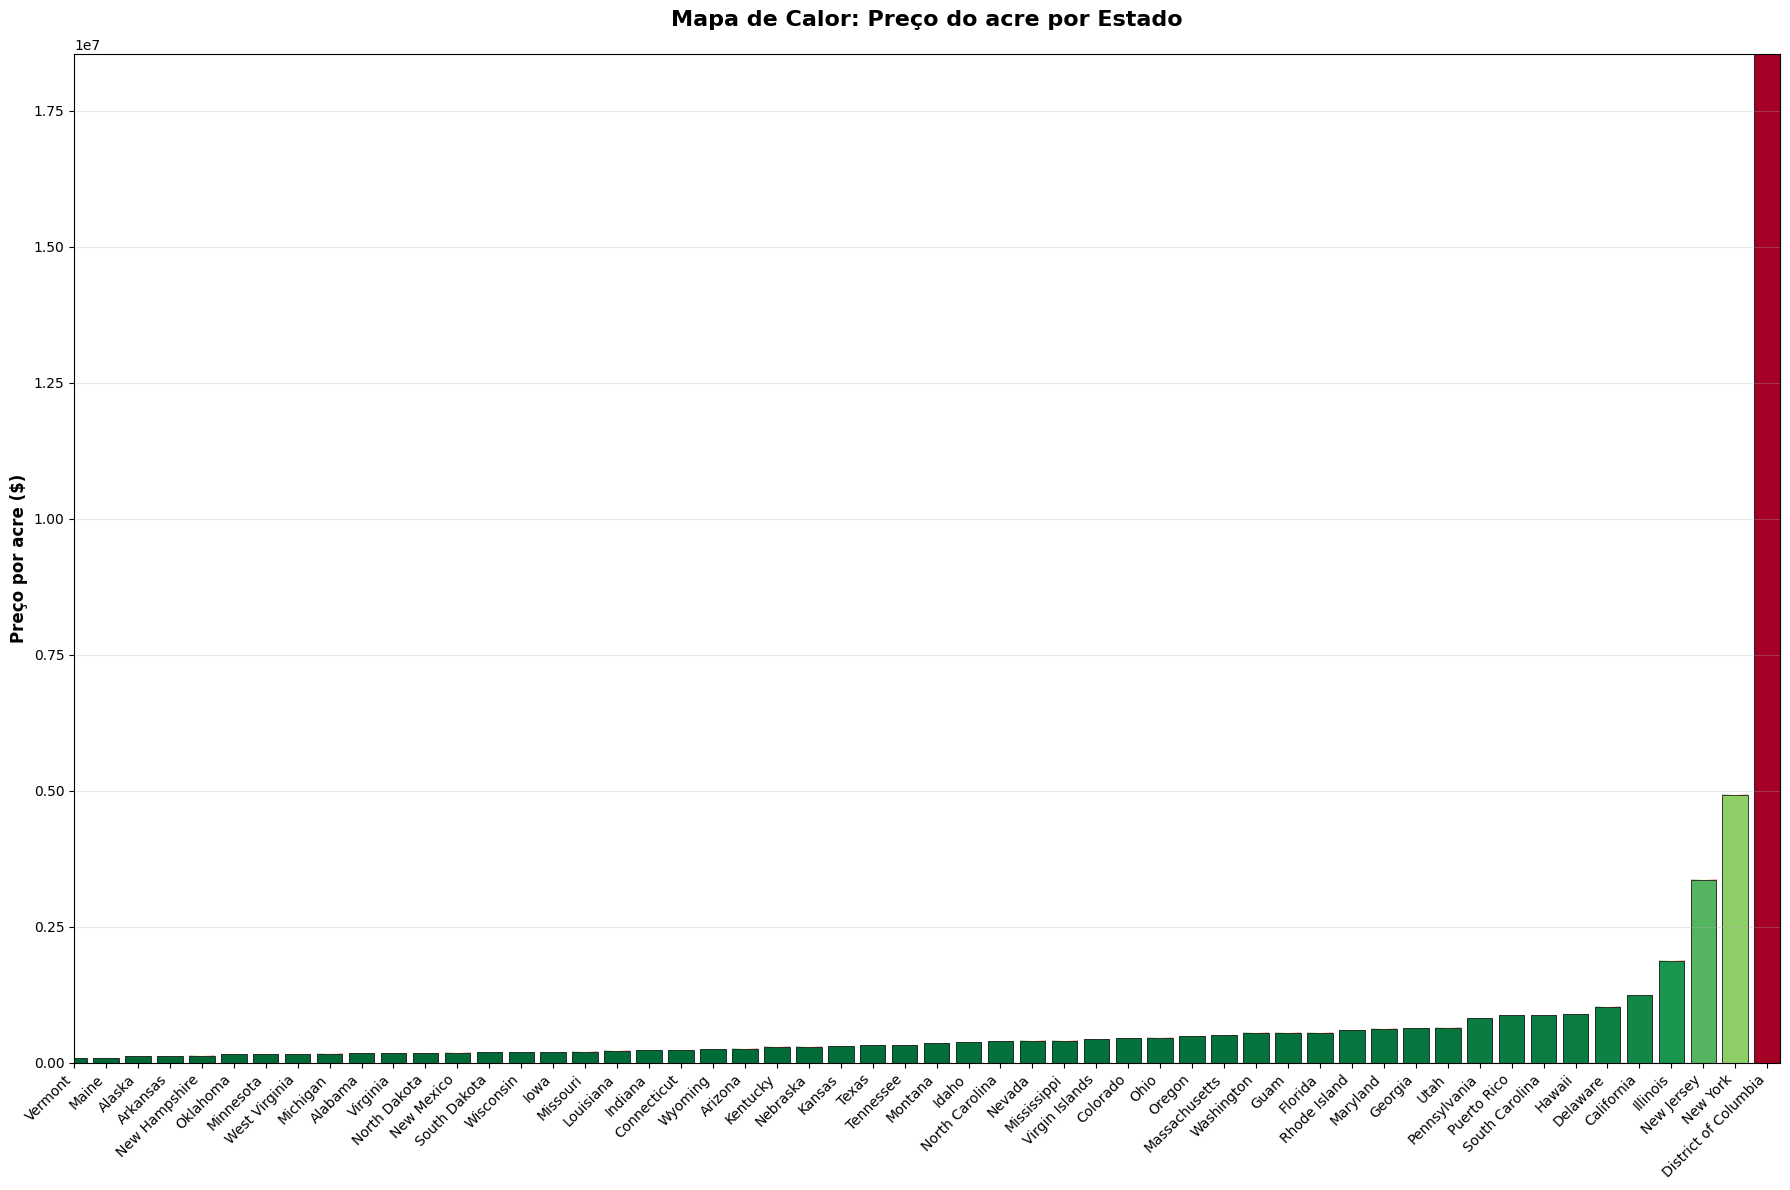

In [15]:
db.rollback()
cur.execute('''
    SELECT state, AVG(price_per_acre) as avg_price_per_acre 
    FROM silver.one_big_table 
    WHERE acre_lot IS NOT NULL 
    GROUP BY state 
    ORDER BY avg_price_per_acre
''')
data = cur.fetchall()

fig, ax = plt.subplots(figsize=(18, 12))

states = [row[0] for row in data]
prices = [row[1] for row in data]

norm = plt.Normalize(min(prices), max(prices))
colors = plt.cm.RdYlGn_r(norm(prices))

x_pos = np.arange(len(states))
bars = ax.bar(x_pos, prices, color=colors, edgecolor='black', linewidth=0.5)

# Adicionar sombra para efeito 3D
for i, bar in enumerate(bars):
    gradient = np.linspace(0, 1, 100).reshape(1, -1)
    ax.imshow(gradient, extent=[bar.get_x(), bar.get_x() + bar.get_width(), 
                                0, bar.get_height()],
              aspect='auto', cmap='RdYlGn_r', alpha=0.3,
              origin='lower')

ax.set_xticks(x_pos)
ax.set_xticklabels(states, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Preço por acre ($)', fontsize=12, fontweight='bold')
ax.set_title('Mapa de Calor: Preço do acre por Estado', 
             fontsize=16, fontweight='bold', pad=20)

ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()